# Comparación de PHL con otros métodos de selección de instancias

In [28]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')
from my_dataset_reduction import phl_selection, srs_selection, clc_selection, drop3_selection, cnn_selection

import seaborn as sns
import matplotlib.pyplot as plt

# Set path to the notebook directory (Jupyter compatible)

dbnames = ['pima',
           'drybeans',
           'diabetes_binary_5050split',
           'diabetes_binary'
]

dbpaths = ['../datasets/pima.csv',
           '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx',
           '../datasets/diabetes_health_indicators/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
           '../datasets/diabetes_health_indicators/diabetes_binary_health_indicators_BRFSS2015.csv'
]
targets = ['Outcome',
          'Class',
          'Diabetes_binary',
          'Diabetes_binary']

results_folders = ['../results/pima/',
                '../results/drybeans/',
                '../results/diabetes_binary_5050split/',
                '../results/diabetes_binary/']

In [29]:
def read_dataset(dbpath):
    if not os.path.exists(dbpath):
        print(f"{dbpath} does not exist.")
        return pd.DataFrame()

    # Load the dataset
    if dbpath.endswith('.xlsx') or dbpath.endswith('.xls'):
        # Read the Excel file
        df = pd.read_excel(dbpath, )
    else:
        # Read the CSV file
        df = pd.read_csv(dbpath)
    return df

dfs = [read_dataset(dbpath) for dbpath in dbpaths]
print("Tamaños de los datasets:")
for dbname, df in zip(dbnames, dfs):
    print(f"{dbname}: {df.shape}")

Tamaños de los datasets:
pima: (768, 9)
drybeans: (13611, 17)
diabetes_binary_5050split: (70692, 22)
diabetes_binary: (253680, 22)


In [30]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


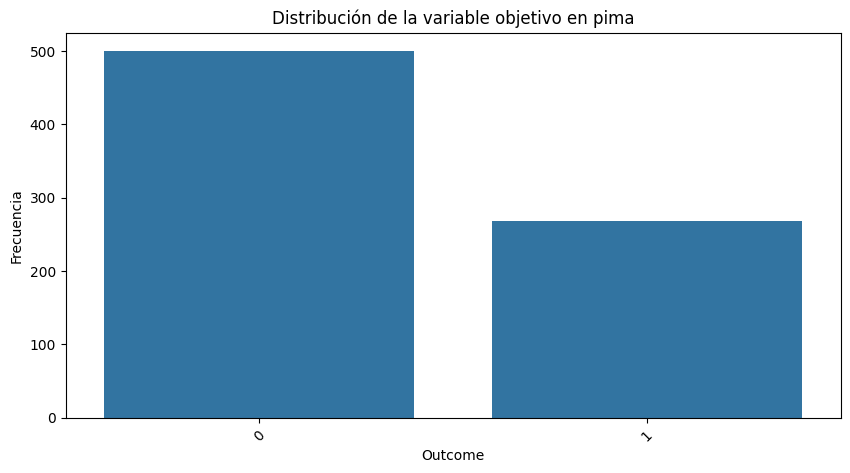

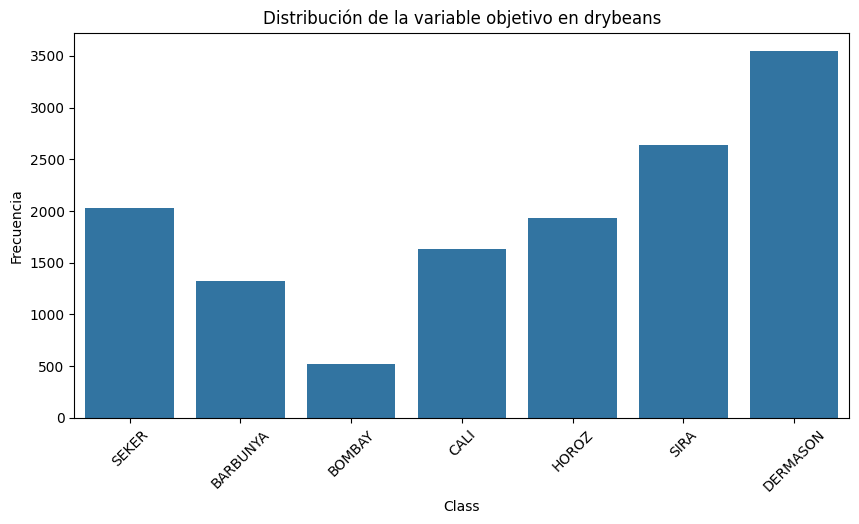

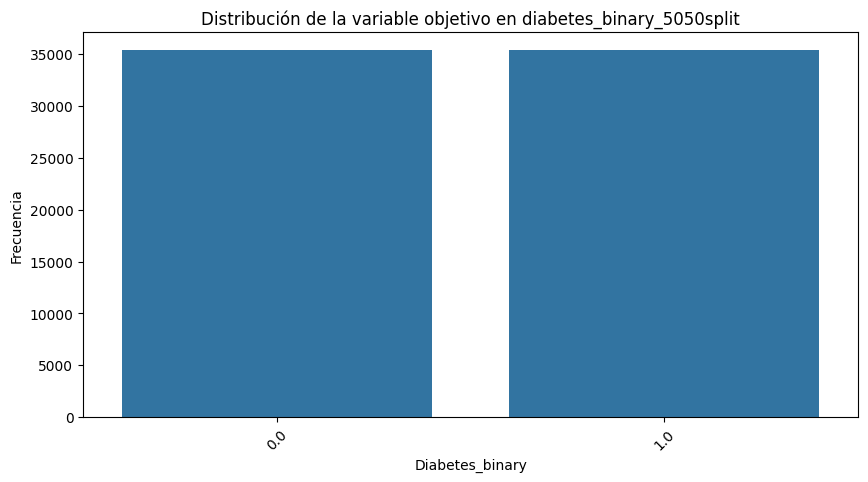

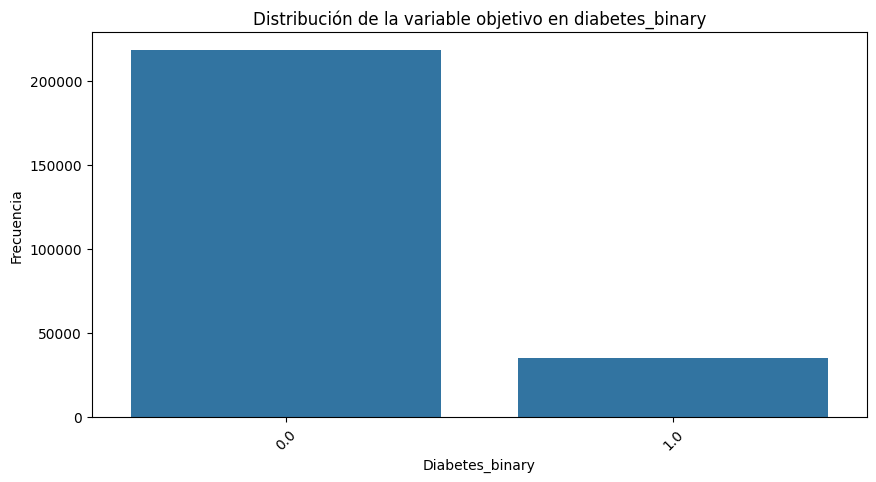

In [31]:
# Show bar plot of the target variable
for dbname, df, target in zip(dbnames, dfs, targets):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=target, data=df)
    plt.title(f'Distribución de la variable objetivo en {dbname}')
    plt.xlabel(target)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

## Comparación de métodos de selección de instancias

In [32]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
df_results = dict()
for dbname, results_folder in zip(dbnames, results_folders):
    df_results[dbname] = pd.read_csv(results_folder + 'results.csv')

In [33]:
results = df_results['diabetes_binary_5050split']
results

,model,reduction_method,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,None,1.00,1.000000,0.000000,0.693472,0.693427,0.003357,0.000000
1,RF,None,1.00,1.000000,0.000000,0.741920,0.741696,4.385280,0.000000
2,XGB,None,1.00,1.000000,0.000000,0.747295,0.747000,0.148638,0.000000
3,XGB,SRS,0.05,0.049989,6.304665,0.715788,0.715681,0.091182,0.015833
4,XGB,SRS,0.10,0.099995,5.077813,0.719419,0.719305,0.151532,0.015990
...,...,...,...,...,...,...,...,...,...
89,RF,PHL_R0_k=3,0.75,0.749987,4.816520,0.738242,0.738008,3.018946,48.893852
90,XGB,PHL_R0_k=3,0.75,0.749987,4.816520,0.742698,0.742376,0.109353,48.893852
91,KNN,PHL_R0_k=3,0.90,0.900005,3.441800,0.693543,0.693514,0.002732,48.895195
92,RF,PHL_R0_k=3,0.90,0.900005,3.441800,0.739798,0.739570,3.644482,48.895195


/tmp/ipykernel_9792/989913642.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()


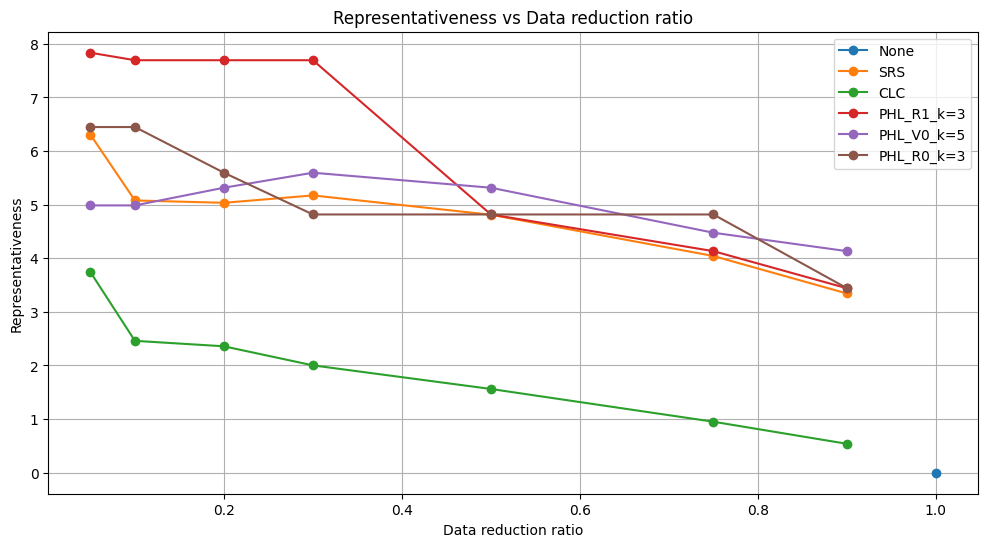

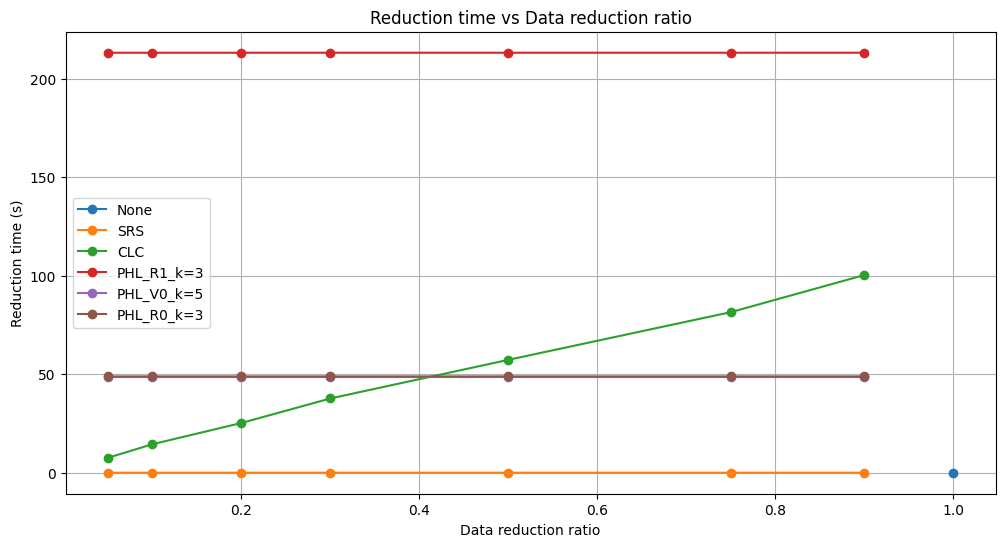

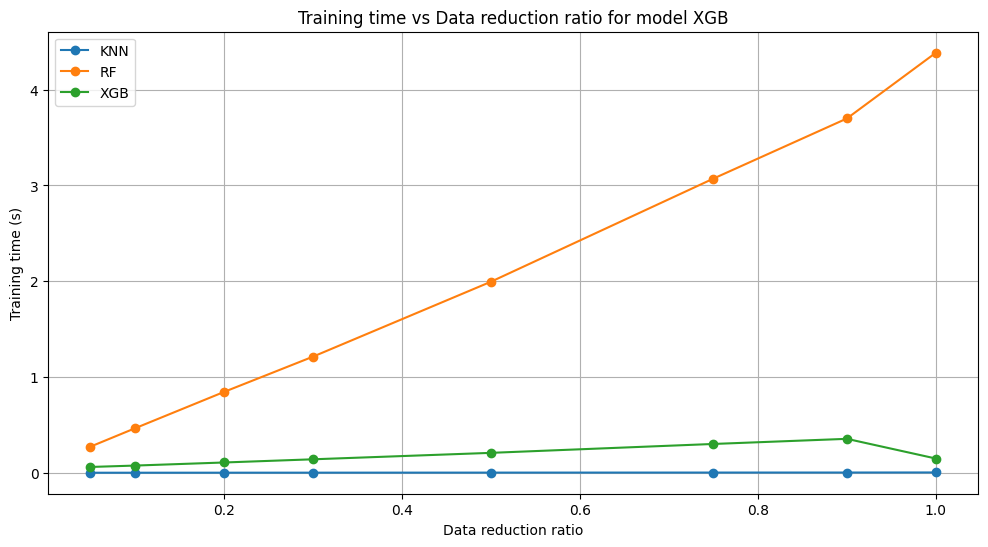

In [34]:
mean_results = results.groupby(['reduction_method', 'percentage'])['representativeness', 'reduction_ratio', 'reduction_time'].mean().reset_index()
mean_training_time = results.groupby(['model', 'percentage'])['training_time'].mean().reset_index()

# Plot representativeness vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in results['reduction_method'].unique():
    plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_results[mean_results['reduction_method'] == reduction_method]['representativeness'],
             label=reduction_method, marker='o')
plt.title(f'Representativeness vs Data reduction ratio')
plt.xlabel('Data reduction ratio')
plt.ylabel('Representativeness')
plt.legend()
plt.grid()
# plt.savefig(f'{results_folder}/representativeness_vs_reduction_ratio.png')
plt.show()

# Plot reduction time vs percentage averaged by model
plt.figure(figsize=(12, 6))
for reduction_method in results['reduction_method'].unique():
    plt.plot(mean_results[mean_results['reduction_method'] == reduction_method]['reduction_ratio'],
             mean_results[mean_results['reduction_method'] == reduction_method]['reduction_time'],
             label=reduction_method, marker='o')
plt.title(f'Reduction time vs Data reduction ratio')
plt.xlabel('Data reduction ratio')
plt.ylabel('Reduction time (s)')
plt.legend()
plt.grid()
# plt.savefig(f'{results_folder}/reduction_time_vs_reduction_ratio.png')
plt.show()

# Plot training time vs percentage averaged by reduction method
plt.figure(figsize=(12, 6))
mean_training_time
for model_name in results['model'].unique():
    plt.plot(mean_training_time[mean_training_time['model'] == model_name]['percentage'],
             mean_training_time[mean_training_time['model'] == model_name]['training_time'],
             label=model_name, marker='o')
plt.title(f'Training time vs Data reduction ratio for model {model_name}')
plt.xlabel('Data reduction ratio')
plt.ylabel('Training time (s)')
plt.legend()
plt.grid()
# plt.savefig(f'{results_folder}/training_time_vs_percentage.png')
plt.show()


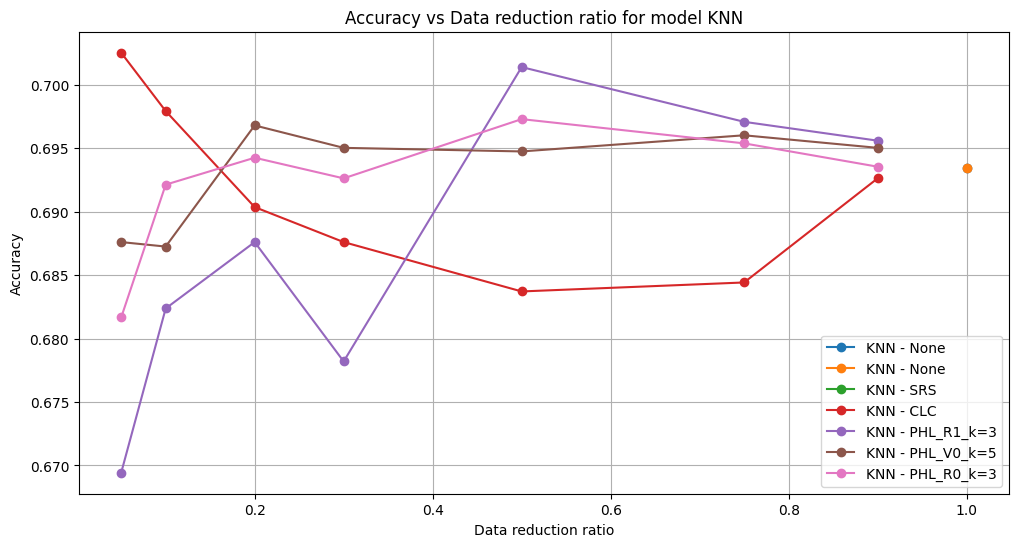

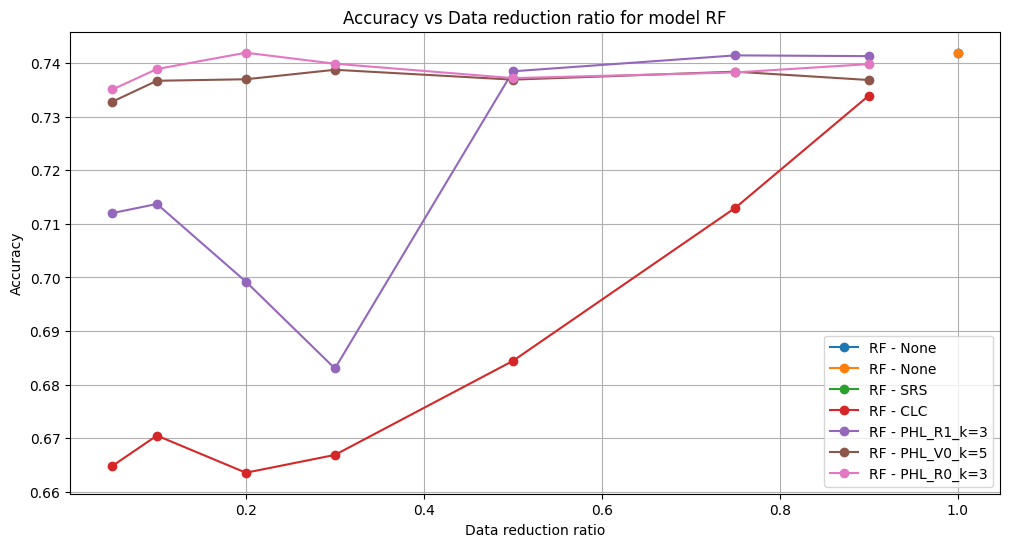

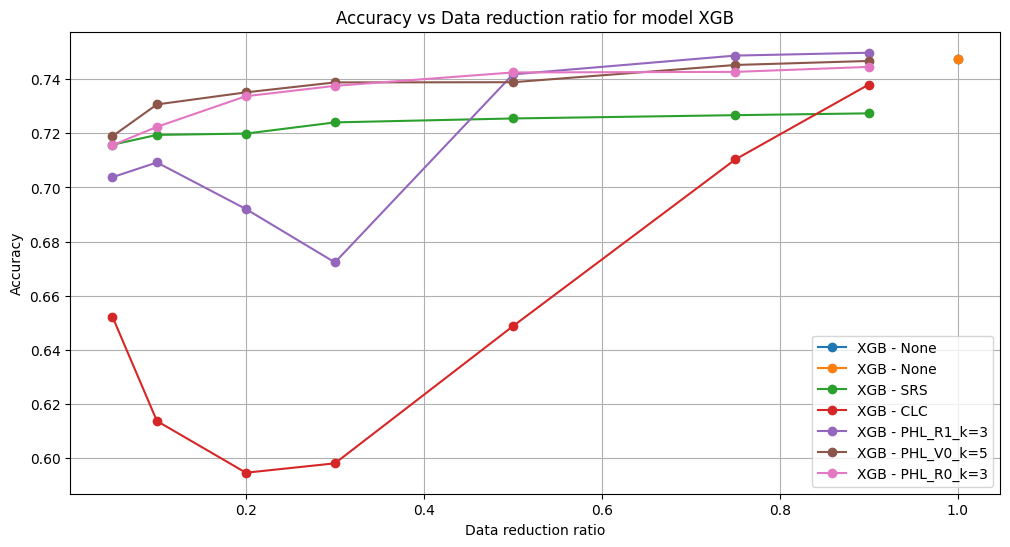

In [35]:
for model_name in results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['accuracy'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in results['reduction_method'].unique():
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['accuracy'],
                 label=f'{model_name} - {reduction_method}', marker='o')
    plt.title(f'Accuracy vs Data reduction ratio for model {model_name}')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{model_name}.png')
    plt.show()


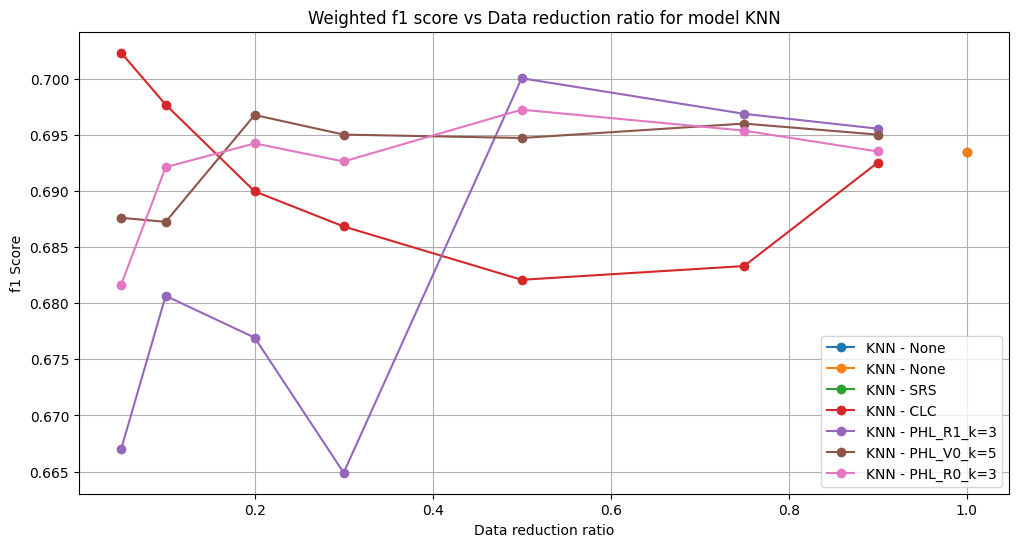

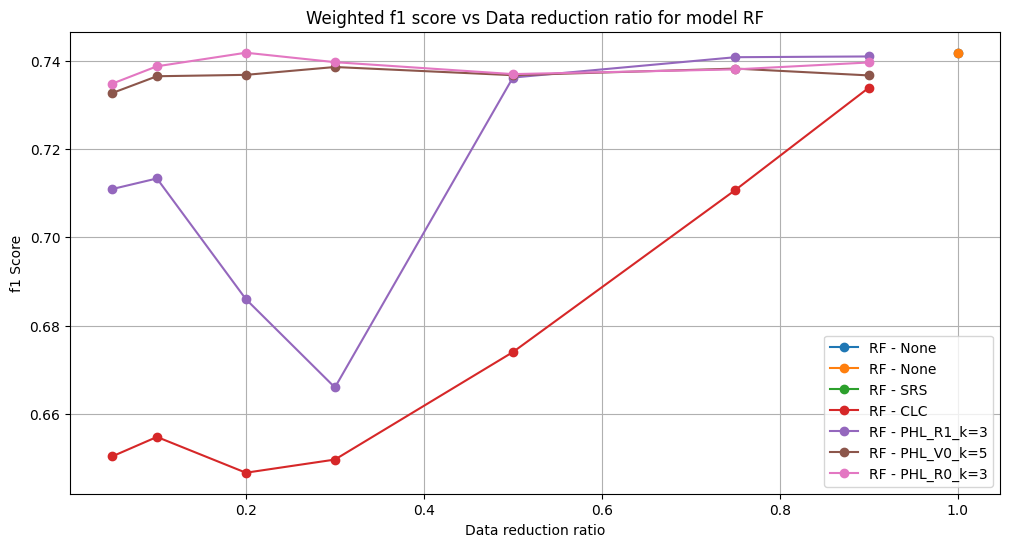

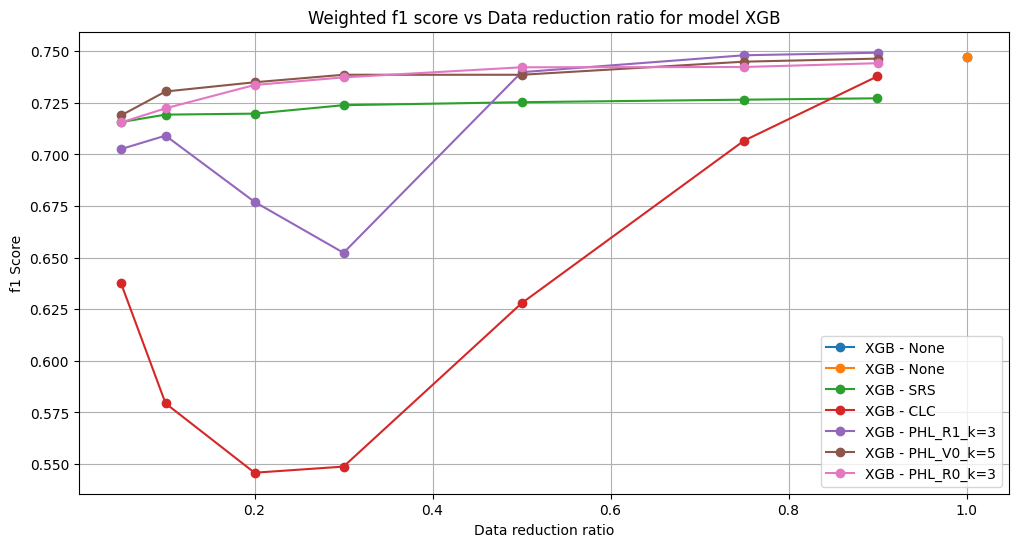

In [36]:
for model_name in results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['reduction_ratio'],
             results[(results['model'] == model_name) & (results['reduction_method'] == 'None')]['f1'],
             label=f'{model_name} - None', marker='o')
    for reduction_method in results['reduction_method'].unique():
        plt.plot(results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['reduction_ratio'],
                 results[(results['model'] == model_name) & (results['reduction_method'] == reduction_method)]['f1'],
                 label=f'{model_name} - {reduction_method}', marker='o')
    plt.title(f'Weighted f1 score vs Data reduction ratio for model {model_name}')
    plt.xlabel('Data reduction ratio')
    plt.ylabel('f1 Score')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/f1_vs_reduction_ratio_{model_name}.png')
    plt.show()
